## Faithfulness experiment analysis

We have run an experiment by generating evaluations on a set of qa-pairs with lynx, vectara and g-eval using different models. This evaluation is a comparison of these approaches, trying to understand where they overlap, and what might be the issues if we were to shift from gpt-4 to gemini as our g-eval evaluator.

In [78]:
import psycopg2
import boto3
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from textwrap import wrap
from itertools import combinations
from matplotlib_venn import venn3, venn2
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import confusion_matrix, f1_score

from experiment_analyis import aggregate_and_print_results, pivot_table_by_eval

In [79]:
load_dotenv(find_dotenv())

True

In [80]:
# getting the secrets from the parameter store relating to the RDS database

session = boto3.Session()

ssm = session.client('ssm')

response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)

secret = response['Parameter']['Value']


In [81]:
conn = psycopg2.connect(**json.loads(secret))

In [5]:
# getting all the qa-pairs relating to the tag: g_eval_comparison_experiment

cur = conn.cursor()

cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, qa.generation, q.prompt
    FROM qapair qa
        JOIN dbquery q ON qa.query_id = q.id
    WHERE pipeline_id = 'g_eval_comparison_experiment' AND evals <> '{}'::jsonb;
""")


rows = cur.fetchall()

print(len(rows))

21747


In [6]:
df = pd.DataFrame(rows, columns=["id", "generation-json", "question", "answer", "evals", "model", "answer-prompt", "updated-at", "generation", "query-prompt"])

In [7]:
raw_evals = pd.DataFrame.from_dict(df[["id", "evals"]].set_index("id").to_dict()["evals"], orient="index")

raw_evals = raw_evals[raw_evals["substring_match-system_response"].apply(lambda x: False if pd.isna(x) else json.loads(x).get("score") == 1)]
raw_evals.drop(columns=["substring_match-system_response"], inplace=True)

evals = raw_evals.applymap(lambda x: x if pd.isna(x) else json.loads(x)["score"])

evals.shape

(20202, 5)

In [8]:
print(f"{raw_evals.dropna(subset=['vectara-faithfulness', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini', 'g_eval-faithfulness_llama3', 'patronus_lynx-faithfulness']).shape[0]} items with all evaluators")
print(f"Evaluators used: {evals.columns.tolist()}")

658 items with all evaluators
Evaluators used: ['g_eval-faithfulness_gemini', 'g_eval-faithfulness_llama3', 'patronus_lynx-faithfulness', 'g_eval-faithfulness_gpt4o', 'vectara-faithfulness']


I messed up on the prompting for g-eval, because that now outputs 5 for violation scaled to 1. For absolute clarity, spelling these out here:
- patronus: 1 is faithful, 0 is violation
- g_eval: 1 is violation, 0 is faithful
- vectara: 1 is faithful, 0 is violation

In [9]:
# turning everything into 1=violation, 0=faithful

transformation_functions = {
    'g_eval-faithfulness_gemini': lambda x: x > 0.8,
    'g_eval-faithfulness_llama3': lambda x: x > 0.8,
    'g_eval-faithfulness_gpt4o': lambda x: x > 0.8,
    'patronus_lynx-faithfulness': lambda x: not x,
    'vectara-faithfulness': lambda x: x <= 0.5,
}

In [10]:
for col in evals.columns:
    evals[col] = evals[col].apply(lambda x: None if pd.isna(x) else int(transformation_functions[col](x)))

In [11]:
global_violation_ratios = {}

for col in evals.columns:
    _tmp = evals[col].dropna()
    print("{:>30}:{:>7}  violations out of {:>6} ({:<6})".format(col, int(_tmp.sum()), int(_tmp.shape[0]), round(_tmp.sum() / _tmp.shape[0], 4)))
    global_violation_ratios[col] = _tmp.sum() / _tmp.shape[0]

    g_eval-faithfulness_gemini:   5678  violations out of  19915 (0.2851)
    g_eval-faithfulness_llama3:  15660  violations out of  20193 (0.7755)
    patronus_lynx-faithfulness:   2985  violations out of  13738 (0.2173)
     g_eval-faithfulness_gpt4o:   3406  violations out of   7110 (0.479 )
          vectara-faithfulness:    991  violations out of   2518 (0.3936)


These are all really high percentages, but llama3 is on the useless side. With 77.5% of the items flagged as violation, it would desensitivise users to the risk of hallucinations.

In [12]:
def get_f1_score_and_count(_evals: pd.DataFrame, model1: str, model2: str) -> tuple[float, int]:
    _evals = _evals.dropna(subset=[model1, model2]).copy()
    y_true = _evals[model1]
    y_pred = _evals[model2]
    return f1_score(y_true, y_pred), y_true.shape[0]

In [13]:
df_f1s = pd.DataFrame(index=evals.columns, columns=evals.columns)
df_counts = pd.DataFrame(index=evals.columns, columns=evals.columns)

for model1, model2 in combinations(evals.columns, 2):
    df_f1s.loc[model1, model2], df_counts.loc[model1, model2] = get_f1_score_and_count(evals, model1, model2)

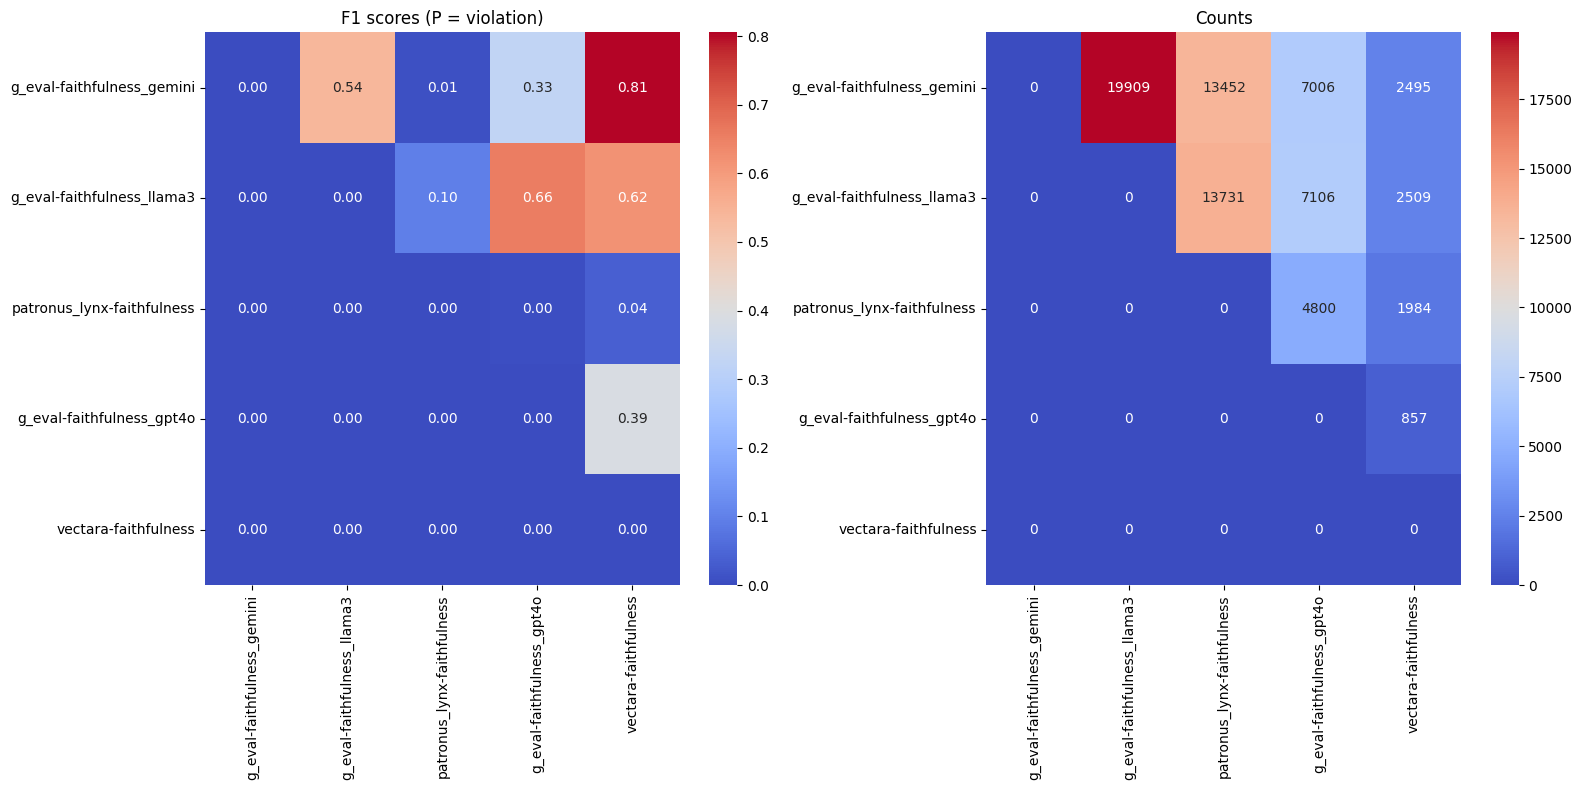

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for _ax, title, _df, fmt in zip(ax, ["F1 scores (P = violation)", "Counts"], [df_f1s, df_counts], [".2f", ".0f"]):
    sns.heatmap(_df.fillna(0).astype(float), annot=True, cmap="coolwarm", ax=_ax, fmt=fmt)
    _ax.set_title(title)

plt.tight_layout()

This is pretty interesting. The llama3 values can largely be discarded, as they're distorte by the number of flagged violations. The most valuable parts here are:
- patronus-linx seems to be the odd one out, with ~0 f1-measure with all the other evaluators -- this requires further analysis
- there's a surprisingly high agreement between vectara and gemini
- there's a surprisingly low agreement between gemini and gpt-4o

In [15]:
def _get_violation_ratio_scores(_evals: pd.DataFrame, global_violation_ratios: dict[str, float]) -> dict:
    violation_ratios = (_evals.sum(axis=0) / _evals.shape[0]).to_dict()
    return {k: violation_ratios[k] / global_violation_ratios[k] for k in violation_ratios}


def draw_venn_with_violation_ratios(models: list[str], evals: pd.DataFrame, global_violation_ratios: dict[str, float]):
    """Draws a venn diagram of 2 or 3 model comparisons, and prints the violation ratios of the models"""
    venn = None
    if len(models) == 2:
        venn = venn2
    elif len(models) == 3:
        venn = venn3
    else:
        raise ValueError("Only 2 or 3 models are supported")

    _evals = evals[models].dropna(subset=models)

    print(_get_violation_ratio_scores(_evals, global_violation_ratios))

    venn(
        [set(i for i, x in enumerate(_evals[col].tolist()) if x == 1) for col in models],
        set_labels=models
    )

    plt.show()

I have noticed, that there is some biased sampling going on when picking those subsamples, which all models have a score for. Hence, I'm including the violation ratios checked against those of the dataset. If we're seeing these numbers diverge from 1, that suggests, that the sample is biased, and might not be representative.

{'g_eval-faithfulness_llama3': 1.070749689365256, 'patronus_lynx-faithfulness': 1.000174616192657}


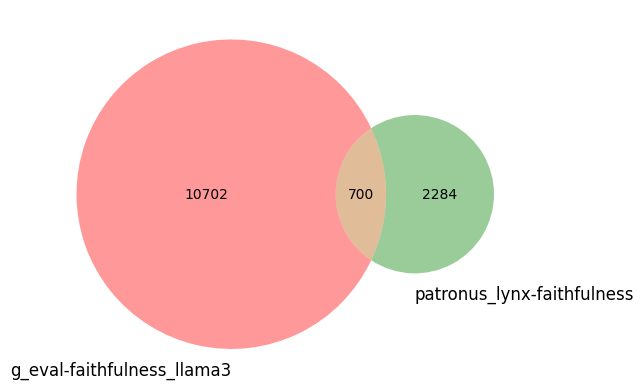

In [16]:
draw_venn_with_violation_ratios(['g_eval-faithfulness_llama3', 'patronus_lynx-faithfulness'], evals, global_violation_ratios)

{'vectara-faithfulness': 0.9468328160996135, 'g_eval-faithfulness_gpt4o': 1.2283712704550238, 'g_eval-faithfulness_gemini': 1.7826510547163166}


/Users/matyasjuhasz/git/document-qa-prototype/.venv/lib/python3.11/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


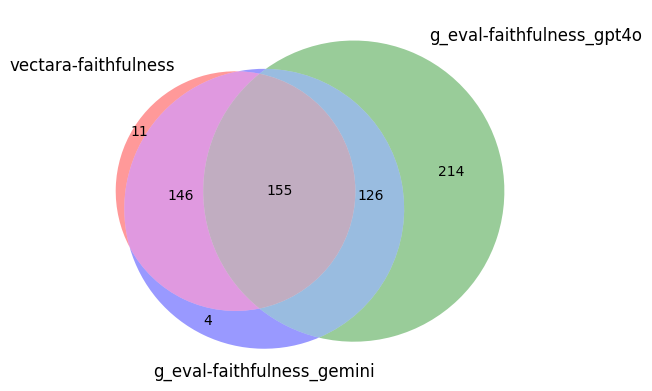

In [17]:
draw_venn_with_violation_ratios(['vectara-faithfulness', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini'], evals, global_violation_ratios)


This is pretty interesting. It seems like vectara is fully entailed in the gemini flags, and that gpt-4o and gemini overlap highly on this sample (which is not what the above heatmap was showing).
<br><br>
The sample ratios / global violation ratios show us the discrepancy between the sample and the global dataset. This discrepancy is large here: 178% for gemini, 123% for gpt-4o, so the fidelity of this graph is **low**.

{'g_eval-faithfulness_gemini': 0.9922439046609974, 'g_eval-faithfulness_gpt4o': 1.0139505455352504}


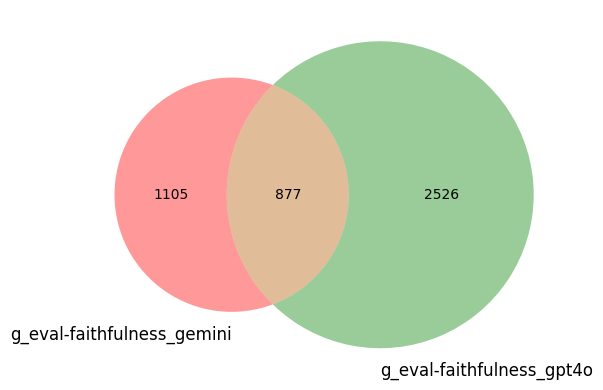

In [18]:
draw_venn_with_violation_ratios(['g_eval-faithfulness_gemini', 'g_eval-faithfulness_gpt4o'], evals, global_violation_ratios)


This confirms a lot better what we're seeing in the pairwise comparison above, also suggested by the good violation ratio scores.

In [19]:
evals.value_counts(normalize=True)

g_eval-faithfulness_gemini  g_eval-faithfulness_llama3  patronus_lynx-faithfulness  g_eval-faithfulness_gpt4o  vectara-faithfulness
1.0                         1.0                         0.0                         1.0                        1.0                     0.235562
                                                                                    0.0                        1.0                     0.220365
                                                                                    1.0                        0.0                     0.170213
0.0                         1.0                         1.0                         0.0                        0.0                     0.123100
                                                        0.0                         1.0                        0.0                     0.121581
                            0.0                         1.0                         0.0                        0.0                     0.060790
    

NOTE: 1 is violation in the above.

In addition to the venn-diagram, this is also valuable: those 155 that only vectara flags and not gpt-4o or gemini are also missed by the llama models.
- 23.6% of the cases is flagged by all but Lynx
- 22% is by all but Lynx & gpt-4o
- 17% are flagged byLllama, Gemini and gpt-4o
- 12% Llama and Lynx
- 6% Gemini and Lynx

There is no single qa-pair where all agree! But again, this is on a subsample, so lower reliability than the above ones.

In [20]:
# checking violation ratio scores for this subsample:

_get_violation_ratio_scores(evals.dropna(), global_violation_ratios)

{'g_eval-faithfulness_gemini': 2.2014512901606045,
 'g_eval-faithfulness_llama3': 1.197359058565955,
 'patronus_lynx-faithfulness': 0.8882945629871751,
 'g_eval-faithfulness_gpt4o': 1.1262308424075518,
 'vectara-faithfulness': 1.185480878054466}

This shows, that the above numbers are mostly unreliable, in particular those relating to gemini, the flags of which are overrepresented at 220% of the global distribution.

{'patronus_lynx-faithfulness': 0.9898570079243464, 'g_eval-faithfulness_gpt4o': 0.8766046689827852, 'g_eval-faithfulness_gemini': 1.216684341008333}


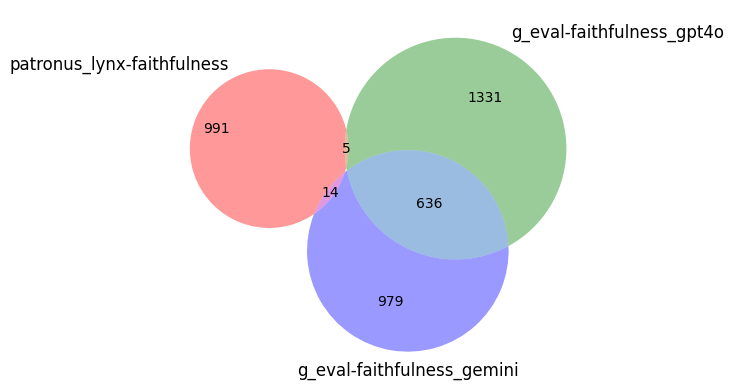

In [21]:
draw_venn_with_violation_ratios(['patronus_lynx-faithfulness', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini'], evals, global_violation_ratios)


{'g_eval-faithfulness_llama3': 0.998537928189506, 'g_eval-faithfulness_gpt4o': 1.0140868241267962, 'g_eval-faithfulness_gemini': 0.9926689698779021}


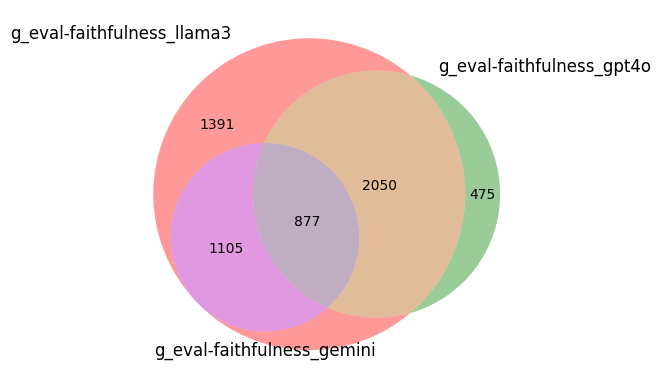

In [22]:
draw_venn_with_violation_ratios(['g_eval-faithfulness_llama3', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini'], evals, global_violation_ratios)


In [60]:
_tmp_df = evals.merge(df, left_index=True, right_on="id")[["query-prompt"] + list(evals.columns)]

_tmp_df.groupby("query-prompt").sum()

,g_eval-faithfulness_gemini,g_eval-faithfulness_llama3,patronus_lynx-faithfulness,g_eval-faithfulness_gpt4o,vectara-faithfulness
query-prompt,,,,,
evals-0.0.1/queries-ambiguous,5416.0,15399.0,2984.0,3307.0,991.0
evals-0.0.1/queries-factual-errors,261.0,261.0,0.0,99.0,0.0
evals-0.0.1/queries-normal,1.0,0.0,1.0,0.0,0.0


In [75]:
_tmp_df = evals.merge(df, left_index=True, right_on="id")[["model"] + list(evals.columns)]

_tmp_df.groupby("model").sum()

,g_eval-faithfulness_gemini,g_eval-faithfulness_llama3,patronus_lynx-faithfulness,g_eval-faithfulness_gpt4o,vectara-faithfulness
model,,,,,
climate-gpt-7b,5678.0,15660.0,2985.0,3406.0,991.0


In [61]:
df["query-prompt"].value_counts()

evals-0.0.1/queries-ambiguous           21304
evals-0.0.1/queries-factual-errors        270
evals-0.0.1/queries-policy-violation      165
evals-0.0.1/queries-normal                  6
evals-0.0.1/queries-partial-answer          2
Name: query-prompt, dtype: int64

In [76]:
df["model"].value_counts()

climate-gpt-7b    21747
Name: model, dtype: int64

At this point we realised, that the distribution is not what we wanted from this experiment, so this has to be mitigated. 

## Sampling and inspecting data
After the largely confusing and unclear results above, we need to look at the data, and maybe that gives us some signposts as to the behaviour differences of the models. 

In [68]:
_tmp_df = evals[evals["patronus_lynx-faithfulness"] == 1].merge(df, left_index=True, right_on="id")[["question", "answer", "model", "answer-prompt", "query-prompt", "generation"]]

_tmp_df["sources"] = _tmp_df["generation"].apply(lambda x: [i["page_content"] for i in json.loads(x)["rag_response"]["retrieved_documents"]])

In [69]:
def wrapped(x: str):
    return "\n".join(wrap(x.replace("\n", "NNNNN"), 100)).replace("NNNNN", "\n")

def format_row(row: pd.Series):
    question = wrapped(row["question"])
    answer = wrapped(row["answer"])
    model = wrapped(row["model"])
    sources = wrapped("\n\t".join([f"[{i}]: {t}" for i, t in enumerate(row["sources"])]))

    return "=" * 50 + f"\nQuestion ({row['query-prompt']}):\n{question}\n\nAnswer:\n{answer}\n\nModel:\n{model}\n\nSources:\n{sources}"

In [74]:
print(
    format_row(
        _tmp_df.sample(1).iloc[0]
    )
)

Question (evals-0.0.1/queries-ambiguous):
Economic implications

Answer:
 - Economic implications of climate change include: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
192, 193, 194, 195, 196, 19

## New experiment
We need a SQL query that selects a good distribution of items.

In [85]:
conn = psycopg2.connect(**json.loads(secret))

Using partition to make sure we get representative splits of answer-prompt, question-prompt and model:

In [160]:

cur = conn.cursor()

cur.execute("""
    SELECT * 
    FROM (
            SELECT 
                qa.id,
                qa.generation,
                qa.question,
                qa.answer,
                qa.evals,
                qa.model,
                qa.prompt,
                qa.updated_at,
                qa.generation,
                q.prompt,
                ROW_NUMBER() OVER(PARTITION BY qa.model, qa.prompt, q.prompt) AS rn
            FROM qapair qa
                JOIN dbquery q ON qa.query_id = q.id
            WHERE pipeline_id = 'main_answer_run_2024_08_10' 
                AND qa.model NOT IN ('neural-chat-7b')
                AND qa.prompt NOT IN ('evals-answers-0.0.1/explain_assumptions', 'evals-answers-0.0.1/branch', 'evals-answers-0.0.1/kg_intermediate')
                AND q.prompt NOT IN ('evals-0.0.1/queries-harmful', 'evals-0.0.1/queries-inference', 'evals-0.0.1/queries-esl', 'evals-0.0.1/queries-complex', 'evals-0.0.1/queries-bias', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-opinions', 'evals-0.0.1/queries-jailbreak', 'evals-0.0.1/queries-nonsense')
        ) a
    WHERE rn < 750;
""")


rows = cur.fetchall()

print(len(rows))

15406


In [161]:
_df = pd.DataFrame(
    rows,
    columns=["id", "generation-json", "question", "answer", "evals", "model", "answer-prompt", "updated-at", "generation", "query-prompt", "row-number"]
)


_df["query-prompt"].value_counts()

evals-0.0.1/queries-ambiguous              5994
evals-0.0.1/queries-normal                 4558
evals-0.0.1/queries-typo                   3649
evals-0.0.1/queries-bias-equity-risk        395
evals-0.0.1/queries-climate-controversy     330
evals-0.0.1/queries-controversial           230
evals-0.0.1/queries-indigenous               80
evals-0.0.1/queries-long                     50
evals-0.0.1/queries-no-answer                45
evals-0.0.1/queries-numerical                30
evals-0.0.1/queries-partial-answer           15
evals-0.0.1/queries-pii                      10
evals-0.0.1/queries-search-terms             10
evals-0.0.1/queries-policy-violation          5
evals-0.0.1/queries-sections                  5
Name: query-prompt, dtype: int64

In [162]:
_df["model"].value_counts()

gemini-1.5-pro          4715
climate-gpt-7b          3322
mistral-nemo            3249
gemini-1.5-flash        2247
llama3-1-8b-instruct    1873
Name: model, dtype: int64

In [163]:
_df["answer-prompt"].value_counts()

evals-answers-0.0.1/basic_answer            10011
evals-answers-0.0.1/chain_of_thought         5388
evals-answers-0.0.1/basic_answer_refined        7
Name: answer-prompt, dtype: int64